In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import re
import os
import csv
import copy
import json
import logging
from dataclasses import dataclass, field
from typing import Optional, Dict, Sequence, Tuple, List
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import transformers
from transformers import Trainer, TrainingArguments
from transformers import TrainerCallback
import sklearn
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from scipy.special import softmax

import torch.nn.functional as F
import matplotlib as mpl
torch.manual_seed(0)
np.random.seed(0)

In [72]:
@dataclass
class TrainingArguments(transformers.TrainingArguments):
    cache_dir: Optional[str] = field(default=None)
    run_name: str = field(default="run")
    optim: str = field(default="adamw_torch")
    model_max_length: int = field(default=1024, metadata={"help": "Maximum sequence length."})
    gradient_accumulation_steps: int = field(default=1)
    per_device_train_batch_size: int = field(default=4)
    per_device_eval_batch_size: int = field(default=4)
    num_train_epochs: int = field(default=2)
    fp16: bool = field(default=False)
    #logging_steps: int = field(default=100)
    save_steps: int = field(default=500)
    eval_steps: int = field(default=500)
    evaluation_strategy: str = field(default="steps")
    load_best_model_at_end: bool = field(default=True)     # load the best model when finished training (default metric is loss)
    metric_for_best_model: str = field(default="eval_loss") # the metric to use to compare models
    greater_is_better: bool = field(default=False)           # whether the `metric_for_best_model` should be maximized or not
    logging_strategy: str = field(default="steps")  # Log every "steps"
    logging_steps: int = field(default=500)  # Log every 500 steps
    warmup_ratio: int = field(default=0.1)
    weight_decay: float = field(default=1e-2)
    learning_rate: float = field(default=1e-5)
    lr_scheduler_type: str = field(default='linear')
    save_total_limit: int = field(default=10)
    load_best_model_at_end: bool = field(default=True)
    output_dir: str = field(default="./output")
    find_unused_parameters: bool = field(default=False)
    checkpointing: bool = field(default=False)
    dataloader_pin_memory: bool = field(default=False)
    eval_and_save_results: bool = field(default=True)
    save_model: bool = field(default=False)
    seed: int = field(default=42)
    logging_first_step: bool = field(default=True)
    early_stopping_patience: int = field(default = 5)  # number of evaluations without improvement to wait
    early_stopping_threshold: float = field(default = 1e-3)  # threshold for an improvement
training_args = TrainingArguments()

In [73]:
@dataclass
class ModelArguments:
    #model_name_or_path: Optional[str] = field(default="bert-base-uncased")
    model_name_or_path: Optional[str] = field(default="facebook/esm1b_t33_650M_UR50S")
    #model_name_or_path: Optional[str] = field(default="facebook/esm2_t33_650M_UR50D")
model_args = ModelArguments()

In [74]:
class CustomCallback(TrainerCallback):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.step_count = 0
        self.alphabet = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}

    def compute_pll_for_sequence(self, sequence, model):
        #tokens = self.tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        tokens = self.tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        model_device = next(model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)
            
        with torch.no_grad():
            outputs = model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
        
        logits = torch.log_softmax(outputs.logits, dim=-1)
        #print('logits',logits)
        idx = [self.alphabet[t] for t in sequence]
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item()
    
    def save_model(self, model, path):
        torch.save(model.state_dict(), path) 

    def on_step_end(self, args, state, control, model=None, **kwargs):
        self.step_count += 1

        if self.step_count == 1 or self.step_count % 50 == 0:  # You can adjust the frequency as needed.
            all_sequences = []
            df = pd.read_csv("./cm_data/cm_test_data_1024.csv")
            all_sequences = df['wt_seq'].tolist()

            all_plls_wt = []
            all_plls_wt_weighted = []
            for seq in all_sequences:
                wt_pll = self.compute_pll_for_sequence(seq, model)
                all_plls_wt.append(wt_pll)
                all_plls_wt_weighted.append(wt_pll / len(seq))

            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for all sequences: {all_plls_wt}")
            #logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for all sequences: {all_plls_wt}")
            
            all_sequences = []
            all_sequences = df['mut_seq'].tolist()

            all_plls_mut = []
            all_plls_mut_weighted = []
            for seq in all_sequences:
                mut_pll = self.compute_pll_for_sequence(seq, model)
                all_plls_mut.append(mut_pll)
                all_plls_mut_weighted.append(mut_pll / len(seq))

            all_plls_wt = np.array(all_plls_wt)
            all_plls_mut = np.array(all_plls_mut)
            
            all_plls_wt_weighted = np.array(all_plls_wt_weighted)
            all_plls_mut_weighted = np.array(all_plls_mut_weighted)
        
        # Compute the PLLR
            PLLR_callback = np.abs(all_plls_wt - all_plls_mut)
            PLLR_weighted_callback = np.abs(all_plls_wt_weighted - all_plls_mut_weighted)
        
        # Get true labels
            true_labels_callback = df['labels'].to_numpy()

            
            # Compute metrics for PLLR_callback
            fpr, tpr, _ = roc_curve(true_labels_callback, PLLR_callback)
            roc_auc = auc(fpr, tpr)
            aupr = average_precision_score(true_labels_callback, PLLR_callback)

            # Compute metrics for PLLR_weighted_callback
            fpr_weighted, tpr_weighted, _ = roc_curve(true_labels_callback, PLLR_weighted_callback)
            roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
            aupr_weighted = average_precision_score(true_labels_callback, PLLR_weighted_callback)

            # Plotting ROC for both PLLR_callback and PLLR_weighted_callback
            #plt.figure()
            plt.figure(figsize=(10, 7))
            mpl.rcParams['font.size'] = 18
            lw = 2  # line width
            plt.plot(fpr, tpr, color='darkorange', lw=lw, label='PLLR ROC curve (area = %0.2f)' % roc_auc)
            plt.plot(fpr_weighted, tpr_weighted, color='darkgreen', lw=lw, label='weighted PLLR ROC curve (area = %0.2f)' % roc_auc_weighted)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) for PLLR and weighted PLLR')
            plt.legend(loc="lower right")
            plt.show()

            # Plotting AUPR for both PLLR_callback and PLLR_weighted_callback
            precision, recall, _ = precision_recall_curve(true_labels_callback, PLLR_callback)
            precision_weighted, recall_weighted, _ = precision_recall_curve(true_labels_callback, PLLR_weighted_callback)

            no_skill = sum(true_labels_callback) / len(true_labels_callback)

            #plt.figure()
            plt.figure(figsize=(10, 7))
            mpl.rcParams['font.size'] = 18
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy')
            plt.plot(recall, precision, color='darkorange', lw=lw, label='PLLR PR curve (area = %0.2f)' % aupr)
            plt.plot(recall_weighted, precision_weighted, color='darkgreen', lw=lw, label='weighted PLLR PR curve (area = %0.2f)' % aupr_weighted)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall curve for PLLR and weighted PLLR')
            plt.legend()
            plt.show()

        
        # Logging
            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for wt sequences: {all_plls_wt}")
            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for mut sequences: {all_plls_mut}")
            logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for wt sequences: {all_plls_wt}")
            logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for mut sequences: {all_plls_mut}")
            print(f"AUC: {roc_auc}")
            print(f"Area Under the Precision-Recall Curve (AUPR): {aupr}")

In [75]:
# Dataset Definition
class SiameseDataset(Dataset):
    def __init__(self, tokenizer, filename):
        data = pd.read_csv(filename)
        self.tokenizer = tokenizer
        # Generating some random sequences for demonstration purposes
        #self.seq_a = ["AGTCCGTA" * 10 for _ in range(num_examples)]
        #self.seq_b = ["TCGATCGA" * 10 for _ in range(num_examples)]
        #self.labels = [np.random.randint(0,2) for _ in range(num_examples)]  # Random binary labels
        self.seq_a = list(data['wt_seq'])
        self.seq_b = list(data['mut_seq'])
        self.labels = list(data['labels'])
        self.num_examples = len(self.labels)
    
    def __len__(self):
        return self.num_examples
    
    def __getitem__(self, idx):
        inputs_a = self.tokenizer(self.seq_a[idx], return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        inputs_b = self.tokenizer(self.seq_b[idx], return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        
        return {
            "input_ids1": inputs_a["input_ids"].squeeze(0), 
            "attention_mask1": inputs_a["attention_mask"].squeeze(0),
            "input_ids2": inputs_b["input_ids"].squeeze(0),
            "attention_mask2": inputs_b["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
#         inputs_a = self.tokenizer(self.seq_a[idx], max_length=training_args.model_max_length)
#         inputs_b = self.tokenizer(self.seq_b[idx], max_length=training_args.model_max_length)
        
#         input_ids1 = torch.tensor(inputs_a["input_ids"]).squeeze(0) if isinstance(inputs_a["input_ids"], list) else inputs_a["input_ids"].squeeze(0)
#         attention_mask1 = torch.tensor(inputs_a["attention_mask"]).squeeze(0) if isinstance(inputs_a["attention_mask"], list) else inputs_a["attention_mask"].squeeze(0)
    
#         input_ids2 = torch.tensor(inputs_b["input_ids"]).squeeze(0) if isinstance(inputs_b["input_ids"], list) else inputs_b["input_ids"].squeeze(0)
#         attention_mask2 = torch.tensor(inputs_b["attention_mask"]).squeeze(0) if isinstance(inputs_b["attention_mask"], list) else inputs_b["attention_mask"].squeeze(0)
        

In [76]:
class SiameseNetwork(nn.Module):
    def __init__(self, model_name_or_path, num_labels, cache_dir=None):
        super(SiameseNetwork, self).__init__()
        
        # Load the base model
        self.base_model = transformers.AutoModelForMaskedLM.from_pretrained(
            model_name_or_path,
            cache_dir=cache_dir,
            output_hidden_states = True
        )
        
        # Classification head
        #self.classifier = nn.Sequential(
        #    nn.Linear(self.base_model.config.hidden_size * 2, 128),
        #    nn.ReLU(),
        #    nn.Linear(128, num_labels)
        #)
        
    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels):
        # Encoding sequences using the same base model
        #output1 = self.base_model(input_ids=input_ids1, attention_mask=attention_mask1).last_hidden_state[:, 0, :]
        #output2 = self.base_model(input_ids=input_ids2, attention_mask=attention_mask2).last_hidden_state[:, 0, :]
        #print(self.base_model)
        outputs1 = self.base_model(input_ids=input_ids1, attention_mask=attention_mask1)
        #print("Shape of logits1:", outputs1.logits.shape)
        output1 = outputs1.hidden_states[-1][:, 0, :]

        outputs2 = self.base_model(input_ids=input_ids2, attention_mask=attention_mask2)
        #print("Shape of logits2:", outputs2.logits.shape)
        output2 = outputs2.hidden_states[-1][:, 0, :]

        #print("Shape of [CLS] 1:", output1.shape)
        #print("Shape of [CLS] 2:", output2.shape)
        
        logits1 = torch.log_softmax(outputs1.logits, dim=-1)
        logits2 = torch.log_softmax(outputs2.logits, dim=-1)
        #print('logits1',logits1)
        #print('logits2',logits2)
        batch_size = input_ids1.shape[0]
        
        
        PLLs1 = torch.zeros(batch_size, device=input_ids1.device)
        PLLs2 = torch.zeros(batch_size, device=input_ids2.device)

        for i in range(batch_size):
            idx1 = input_ids1[i, 1:-1]  # Excluding the special tokens <cls> and <eos>/<pad>
            PLLs1[i] = torch.sum(torch.diag(logits1[i, 1:-1, :][:, idx1]))
        for i in range(batch_size):
            idx2 = input_ids2[i, 1:-1]  # Excluding the special tokens <cls> and <eos>/<pad>
            PLLs2[i] = torch.sum(torch.diag(logits2[i, 1:-1, :][:, idx2]))
        PLLR = torch.abs(PLLs1 - PLLs2)
        #print(PLLR)
    
        
        
        
        # Concatenating the outputs or a distance can be computed
        #combined_out = torch.cat((output1, output2), dim=1)
        # Classifying the combined outputs
        #logits = self.classifier(combined_out)
        #loss = F.cross_entropy(logits, labels)
        
        #return logits, loss
        # Compute cosine similarity between output1 and output2
        cosine_sim = F.cosine_similarity(output1, output2, dim=-1)
        
        target = torch.where(labels == 1, -torch.ones_like(cosine_sim), torch.ones_like(cosine_sim)).float()
        
        # Compute the loss between cosine similarity and the labels
        # Assuming labels are in the range [-1, 1], denoting similarity
        loss = F.mse_loss(cosine_sim, target)
        #print("Shape of PLLs:", PLLs1.shape)
        #print("Shape of cosine_sim:", cosine_sim.shape)
        #print("Shape of target:", target.shape)

        sigmoid_PLLR = torch.sigmoid(PLLR)
        pll_loss = F.binary_cross_entropy(2*sigmoid_PLLR-1, labels.float())
        
        #return (loss, cosine_sim)
        return (pll_loss, PLLR)


In [77]:
model = SiameseNetwork(model_args.model_name_or_path, num_labels=2)
data_path = "./cm_data/"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_args.model_name_or_path, 
                                                       model_max_length=training_args.model_max_length,) 
                                                       #padding_side="right",
                                                       #use_fast=True,
                                                       #trust_remote_code=True)
# tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path,
#         model_max_length=512,
#         padding_side="right",
#         use_fast=True,
#         trust_remote_code=True,
#     )
print("Tokenizer class:", tokenizer.__class__)
print("Tokenizer name:", tokenizer.__class__.__name__)
    
#train_dataset = SiameseDataset(tokenizer, 900)
#test_dataset = SiameseDataset(tokenizer, 100)
train_dataset = SiameseDataset(tokenizer, os.path.join(data_path, 'cm_train_data_1024.csv'))
test_dataset = SiameseDataset(tokenizer, os.path.join(data_path, 'cm_test_data_1024.csv'))
#test_dataset = SiameseDataset(tokenizer, os.path.join(data_path, 'Clinvar_uncertain_ARM_protein.csv'))


Tokenizer class: <class 'transformers.models.esm.tokenization_esm.EsmTokenizer'>
Tokenizer name: EsmTokenizer


In [78]:
# # Multiple sequences
# sequence = "MKLWTA"
# encoded_sequence = tokenizer.encode(sequence, add_special_tokens=True)

# # Output as a list of token IDs
# print("Token IDs:", encoded_sequence)

# # Convert token IDs back to tokens
# tokens = tokenizer.convert_ids_to_tokens(encoded_sequence)
# print("Tokens:", tokens)

# # Multiple sequences
# sequences = ["MKLWTA", "GATCRY"]
# encoded_sequences = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)

# # Output as lists of token IDs
# print("Token IDs:", encoded_sequences['input_ids'])

# # Convert token IDs back to tokens for each sequence
# for i, ids in enumerate(encoded_sequences['input_ids']):
#     print(f"Tokens for sequence {i+1}: {tokenizer.convert_ids_to_tokens(ids)}")



# input_df = pd.read_csv('/common/zhanh/Cardioboost_protein_sequences/cm_train_protein_seq_df.csv')
# print(input_df.loc[0, 'Original_Protein_Sequence'])
# encoded_sequence1 = tokenizer.encode(input_df.loc[0, 'Original_Protein_Sequence'], add_special_tokens=True)

# # Output as a list of token IDs
# print("Token IDs:", encoded_sequence1,len(encoded_sequence1))

# # Convert token IDs back to tokens
# tokens1 = tokenizer.convert_ids_to_tokens(encoded_sequence1)
# print("Tokens:", tokens1)

# print(input_df.loc[0, 'Mutated_Protein_Sequence'])
# encoded_sequence2 = tokenizer.encode(input_df.loc[0, 'Mutated_Protein_Sequence'], add_special_tokens=True)

# # Output as a list of token IDs
# print("Token IDs:", encoded_sequence2,len(encoded_sequence2))

# # Convert token IDs back to tokens
# tokens2 = tokenizer.convert_ids_to_tokens(encoded_sequence2)
# print("Tokens:", tokens2)

# differences = []
# for i, (char1, char2) in enumerate(zip(encoded_sequence1, encoded_sequence2)):
#     if char1 != char2:
#         differences.append((i, char1, char2))

# print(f"Differences found at these positions: {differences}")

In [79]:
def compute_metrics(eval_pred):
    cosine_sims, labels = eval_pred
    mse = ((cosine_sims - labels)**2).mean()
    # Flip the sign of the cosine similarities because we want -1 for label 1 and 1 for label 0
    flipped_cosine_sims = -cosine_sims
    
    # Convert these flipped values to "probabilities" in [0, 1]
    probabilities = (flipped_cosine_sims + 1) / 2  # Now values are between 0 and 1

    # Make binary predictions based on a threshold (e.g., 0.7)
    predictions = (probabilities > 0.1).astype(np.int32)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    auc = roc_auc_score(labels, probabilities)
    return {
        'mse': mse,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc
    }

In [80]:
def compute_metrics_PLLR(eval_pred):
    PLLR, labels = eval_pred
    auc = roc_auc_score(labels, PLLR)
    aupr = average_precision_score(labels, PLLR)
    return {
        'auc': auc,
        'aupr':aupr
    }

In [81]:
# Define compute_metrics for evaluation
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return {
#         'accuracy': (predictions == labels).mean()
#     }

def custom_data_collator(data):
    # Here, we ensure that each item in `data` has the necessary keys.
    input_ids1 = torch.stack([item['input_ids1'] for item in data])
    attention_mask1 = torch.stack([item['attention_mask1'] for item in data])
    input_ids2 = torch.stack([item['input_ids2'] for item in data])
    attention_mask2 = torch.stack([item['attention_mask2'] for item in data])

    # Ensure labels exist or handle its absence
    #labels = [item.get('labels', torch.tensor(-1)) for item in data]  # Using -1 as a default
    #labels = torch.stack(labels)
    labels = torch.stack([item['labels'] for item in data])

    return {
        'input_ids1': input_ids1,
        'attention_mask1': attention_mask1,
        'input_ids2': input_ids2,
        'attention_mask2': attention_mask2,
        'labels': labels
    }

custom_callback_instance = CustomCallback(tokenizer=tokenizer)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_PLLR,
    data_collator=custom_data_collator,
    callbacks=[custom_callback_instance]
)



In [82]:
# Let's assume you've already loaded your trained model into a variable named `model`.

# Create tokens for your test sequences using your tokenizer.
# Assuming `tokenizer` is your tokenizer and `test_seq1` and `test_seq2` are your test sequences.
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move model to device
model.to(device)

test_seq1 = "LAGVER"
test_seq2 = "<mask><mask><mask><mask><mask><mask>"
encoded_sequence = tokenizer.encode(test_seq1, add_special_tokens=True)

# # # Output as a list of token IDs
print("Token IDs:", encoded_sequence)
encoded_sequence = tokenizer.encode(test_seq2, add_special_tokens=True)

# # # Output as a list of token IDs
print("Token IDs:", encoded_sequence)
tokens1 = tokenizer(test_seq1, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
tokens2 = tokenizer(test_seq2, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)  # Assuming test_seq2 contains mask tokens.

label = torch.tensor([1], dtype=torch.int64).to(device)

# # Move tensors to device
tokens1 = {k: v.to(device) for k, v in tokens1.items()}
tokens2 = {k: v.to(device) for k, v in tokens2.items()}

with torch.no_grad():
     outputs1 = model.base_model(input_ids=tokens1['input_ids'], attention_mask=tokens1['attention_mask'])
     output1 = outputs1.hidden_states[-1][:, 0, :]

     outputs2 = model.base_model(input_ids=tokens2['input_ids'], attention_mask=tokens2['attention_mask'])
     output2 = outputs2.hidden_states[-1][:, 0, :]

# # Examine the outputs
print("Output1 shape:", outputs1.logits.shape)
print("Output2 shape:", outputs2.logits.shape)

logits = torch.log_softmax(outputs1.logits, dim=-1)
s = logits[0][1:-1,:].shape
alphabet = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}
idx = [alphabet[t] for t in test_seq1]
PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
            

Token IDs: [0, 4, 5, 6, 7, 9, 10, 2]
Token IDs: [0, 32, 32, 32, 32, 32, 32, 2]
Output1 shape: torch.Size([1, 1024, 33])
Output2 shape: torch.Size([1, 1024, 33])


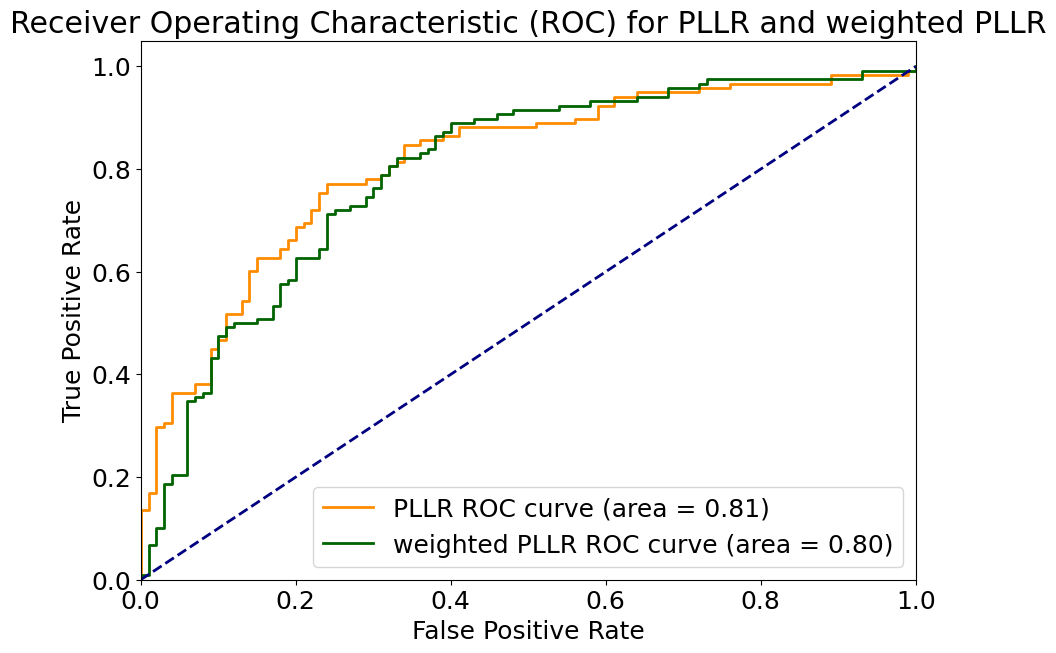

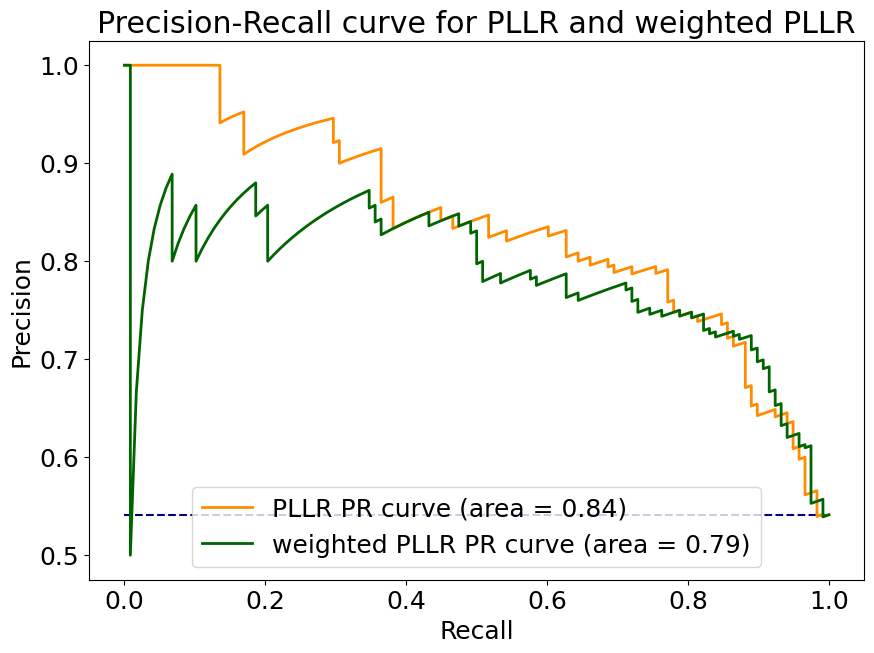

AUC: 0.8114406779661016
Area Under the Precision-Recall Curve (AUPR): 0.8376820587982237


Step,Training Loss,Validation Loss


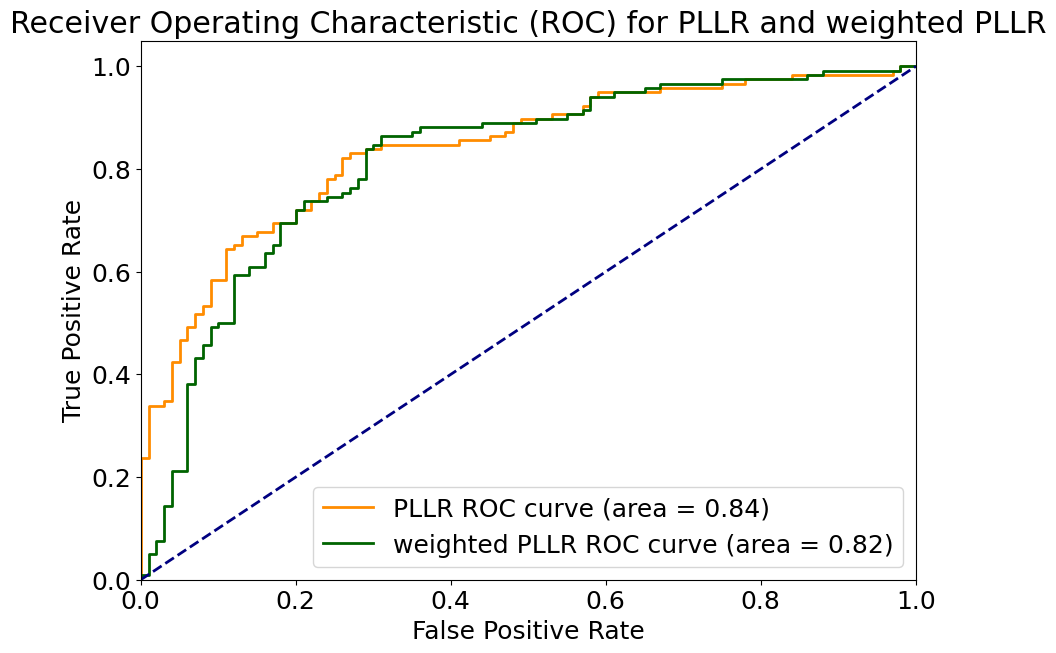

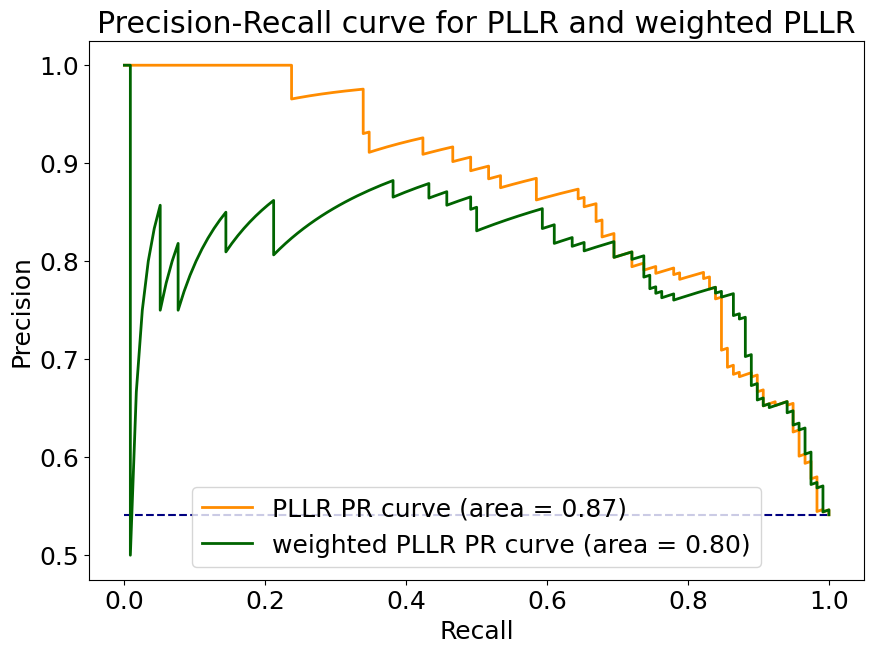

AUC: 0.8384745762711865
Area Under the Precision-Recall Curve (AUPR): 0.8718680334790596


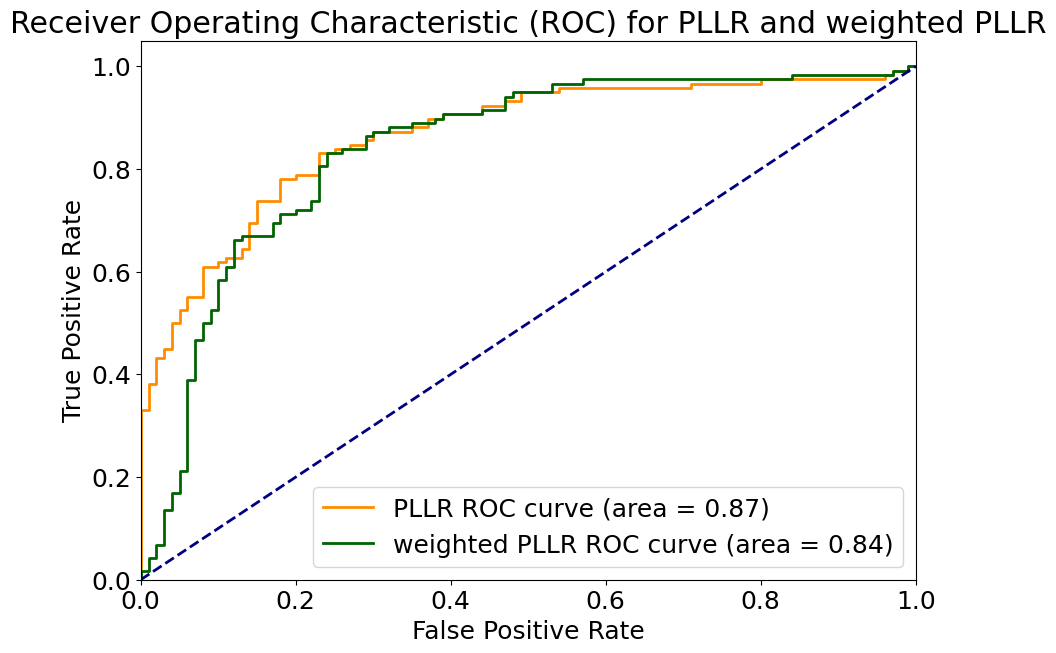

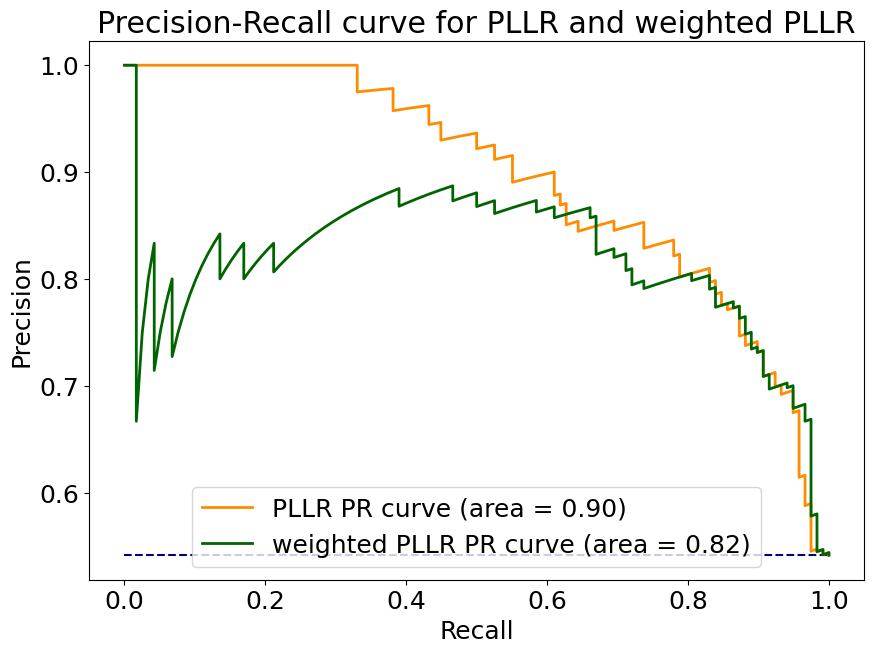

AUC: 0.8655084745762712
Area Under the Precision-Recall Curve (AUPR): 0.8952709717289461


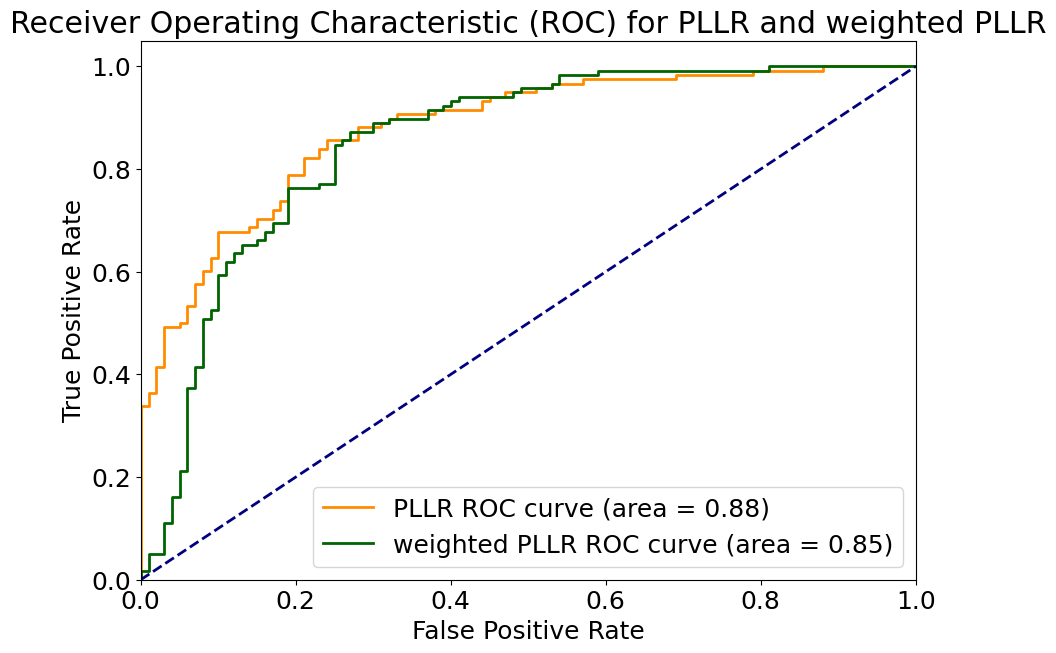

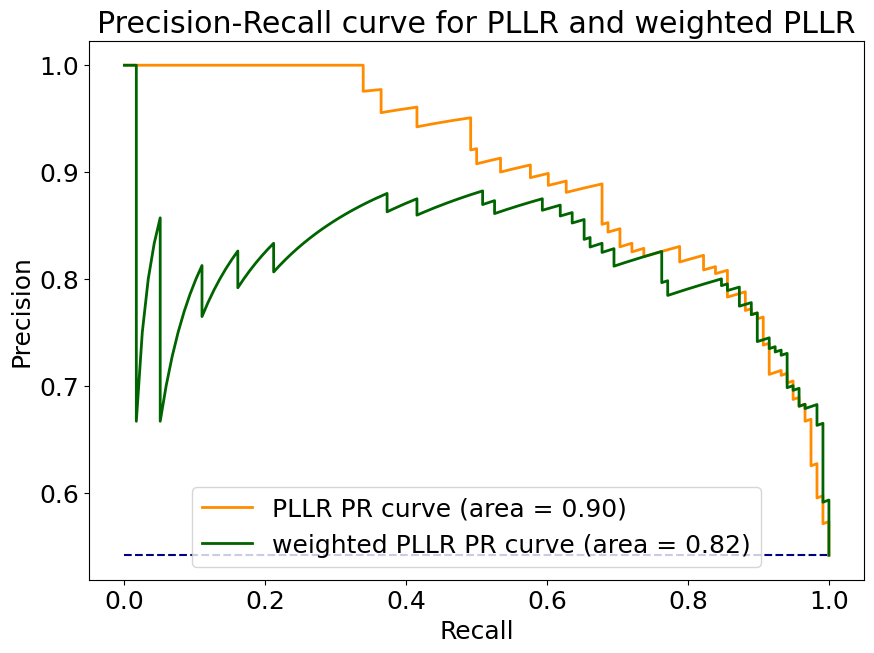

AUC: 0.8798305084745762
Area Under the Precision-Recall Curve (AUPR): 0.9016345407779216


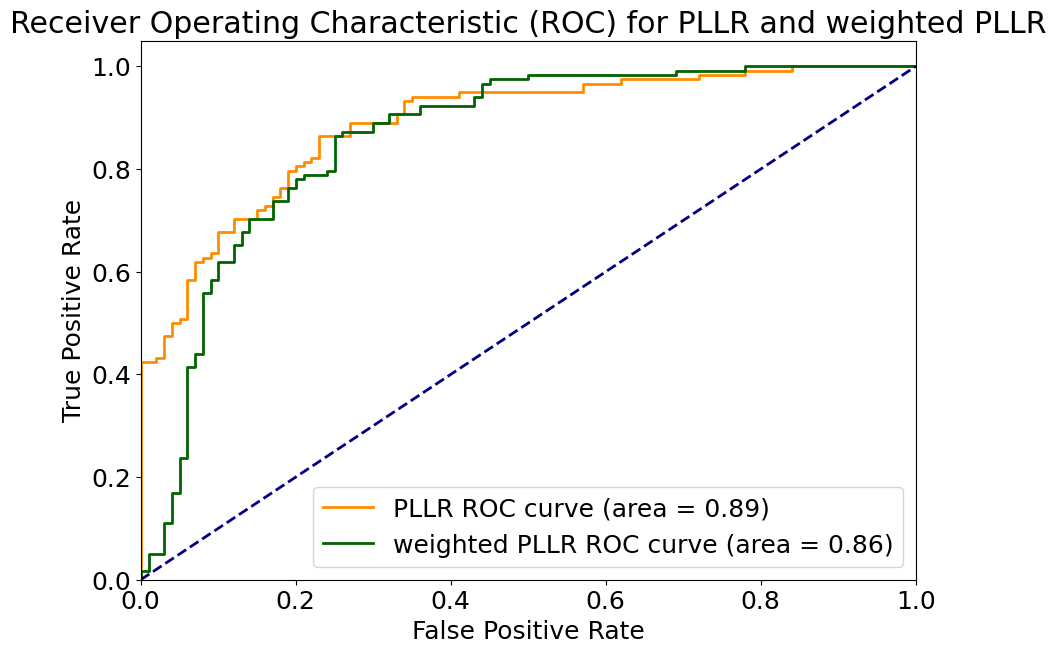

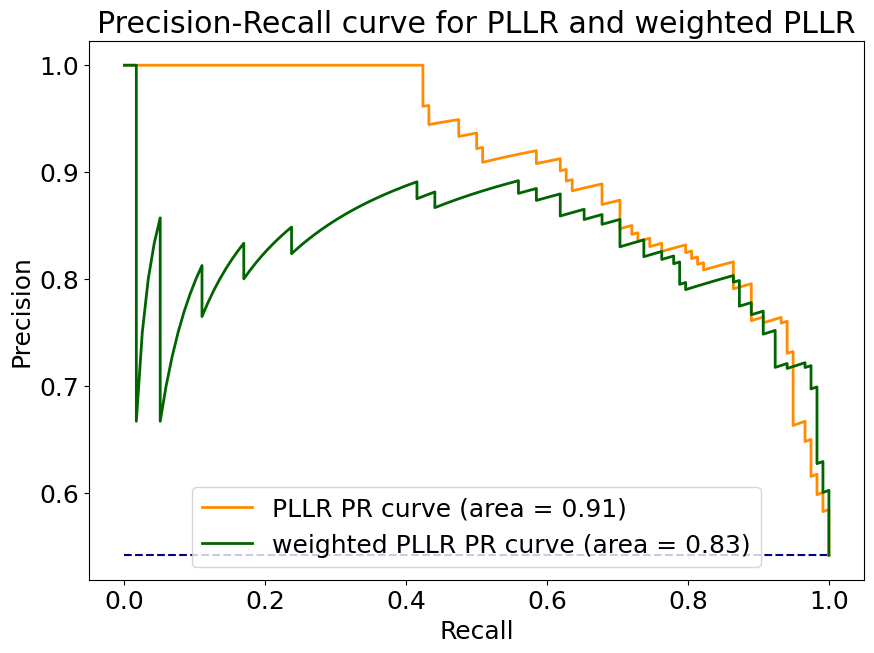

AUC: 0.8877966101694915
Area Under the Precision-Recall Curve (AUPR): 0.9097473121162454


TrainOutput(global_step=220, training_loss=14.849540051546963, metrics={'train_runtime': 859.6267, 'train_samples_per_second': 1.024, 'train_steps_per_second': 0.256, 'total_flos': 0.0, 'train_loss': 14.849540051546963, 'epoch': 2.0})

In [83]:
#results = trainer.evaluate()
#print(results)

# Training
trainer.train()


#results = trainer.evaluate()
#print(results)




In [84]:
cm_model_path = "/common/zhangz2lab/zhanh/esm-variants/"
model = SiameseNetwork(model_args.model_name_or_path, num_labels=2)  # or however you initialize your model
model.load_state_dict(torch.load(cm_model_path+"cm_model_step_350.pth"))
model = model.cuda()

In [85]:
class ModelEvaluator:

    def __init__(self, model, tokenizer, alphabet):
        self.model = model
        self.tokenizer = tokenizer
        self.alphabet = alphabet

    def compute_pll_for_sequence(self, sequence):
        tokens = self.tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        model_device = next(self.model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)  # This line essentially does the .cuda() operation

        with torch.no_grad():
            outputs = self.model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])

        logits = torch.log_softmax(outputs.logits, dim=-1)
        idx = [self.alphabet[t] for t in sequence]
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item()
    
    def compute_weighted_pll_for_sequence(self, sequence):
        pll = self.compute_pll_for_sequence(sequence)
        weighted_pll = pll / len(sequence)
        return weighted_pll
    
    def compute_pll_for_token_id(self, token_ids, attention_mask):
        tokens = {
            'input_ids': torch.tensor([token_ids]).to(device), 
            'attention_mask': torch.tensor([attention_mask]).to(device)
        }
        model_device = next(self.model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)

        with torch.no_grad():
            outputs = self.model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])

        logits = torch.log_softmax(outputs.logits, dim=-1)
        idx = token_ids[1:-1]  # Skip the first and the last token
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item()



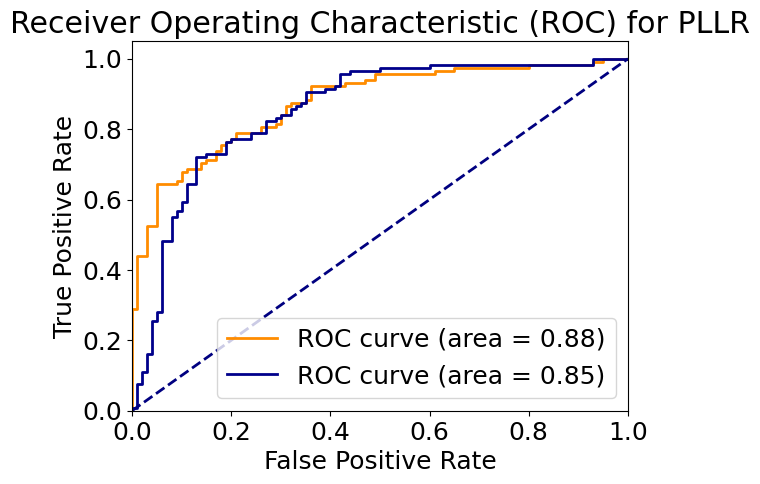

In [86]:
# Create an instance of the evaluator
evaluator = ModelEvaluator(model, tokenizer, alphabet)

# Load sequences
df = pd.read_csv("./cm_data/cm_test_data_1024.csv")
wt_sequences = df['wt_seq'].tolist()
mut_sequences = df['mut_seq'].tolist()

# Compute PLLs for wt sequences
all_plls_wt = [evaluator.compute_pll_for_sequence(seq) for seq in wt_sequences]

# Compute PLLs for mut sequences
all_plls_mut = [evaluator.compute_pll_for_sequence(seq) for seq in mut_sequences]

# Compute weighted PLLs for wt sequences
all_plls_wt_weighted = [evaluator.compute_weighted_pll_for_sequence(seq) for seq in wt_sequences]

# Compute weighted PLLs for mut sequences
all_plls_mut_weighted = [evaluator.compute_weighted_pll_for_sequence(seq) for seq in mut_sequences]

# Compute PLLR
PLLR_callback = np.abs(np.array(all_plls_wt) - np.array(all_plls_mut))
PLLR_weighted_callback = np.abs(np.array(all_plls_wt_weighted) - np.array(all_plls_mut_weighted))
true_labels_callback = df['labels'].to_numpy()

# Create a dictionary with your data
all_data = {
    'all_plls_wt': all_plls_wt,
    'all_plls_mut': all_plls_mut,
    'all_plls_wt_weighted': all_plls_wt_weighted,
    'all_plls_mut_weighted': all_plls_mut_weighted,
    'PLLR_callback': PLLR_callback,
    'PLLR_weighted_callback': PLLR_weighted_callback,
    'true_labels_callback': true_labels_callback
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(all_data)


# Compute AUC and AUPR
fpr, tpr, _ = roc_curve(true_labels_callback, PLLR_callback)
fpr_w, tpr_w, _ = roc_curve(true_labels_callback, PLLR_weighted_callback)

roc_auc = auc(fpr, tpr)
roc_auc_w = auc(fpr_w, tpr_w)

aupr = average_precision_score(true_labels_callback, PLLR_callback)
aupr_w = average_precision_score(true_labels_callback, PLLR_weighted_callback)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_w, tpr_w, color='darkblue', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_w)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for PLLR')
plt.legend(loc="lower right")
plt.show()


